# Tullock contest PNE solver

## Tullock contest-1d and PNE solver

### Utility functions

$$u_i(x_i, x_{-i})=\frac{x_i}{s^{\gamma}+\alpha \cdot s^{\beta}}\cdot\mu-c_ix_i^{\rho}, i\in[n].$$

where $\mu,\alpha\geq0, c_i\in[a,b], 1<\rho\leq 2, 1\geq\gamma\geq\beta\geq 0$, $s=\sum_{j=1}^n x_j$.

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class Tullock(object):
    def __init__(self, n, mu, c, alpha, beta, gamma, rho):
        self.n = n
        self.mu = mu
        self.c = np.array(c)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.rho = rho

        self.h = 1e-3
        self.I = np.eye(n)

    def u(self, x):
        if not isinstance(x, np.ndarray):
           x = np.array(x)

        s = sum(x)
        return x / (s**self.gamma+self.alpha * s**self.beta) * self.mu - self.c * x**self.rho

    def grad(self, x):
        s = np.max([sum(x), 1e-4])
        t0 = s ** self.gamma + self.alpha * s**self.beta
        t1 = self.gamma * s ** (self.gamma-1)
        t2 = self.alpha * self.beta * s ** (self.beta-1)
        g = self.mu / t0 * (1 - x * (t1+t2)/t0) - self.c * self.rho * x**(self.rho-1)
        g = np.clip(g, -10, 10)
        return g

    def BR(self, x=None, lr=0.01, T=100):

        n = self.n
        if x is None:
            x = np.ones(n)
        else:
            x = np.array(x)
        devi_player = 0
        for i in range(T):
            l = list(range(n))
            l.remove(devi_player)
            devi_player = np.random.choice(l, 1)[0]
            u0 = self.u(x)[devi_player]
            u1 = self.u(x + self.I[devi_player] * lr)[devi_player]
            u2 = self.u(x - self.I[devi_player] * lr)[devi_player]

            if u1 > u0:
                x += self.I[devi_player] * lr
                # print('New x:', x)
            elif u2 > u0:
                x -= self.I[devi_player] * lr
                # print('New x:', x)

        return x

    def PGD(self, x=None, lr=0.1, T=100, early_termination=True, verbose=False):
        n = self.n
        if x is None:
            x = np.ones(n)
        else:
            x = np.array(x)

        if verbose:
            rangeT = tqdm(range(T))
        else:
            rangeT = range(T)

        for i in rangeT:

            g = self.grad(x)

            x = np.clip(x + g * lr, 0, np.inf)

            if early_termination and np.linalg.norm(x*g) < 1e-4:
                if verbose:
                    print('\nConverge in '+str(i)+' steps!')
                return x, g, self.u(x)

        print('\nWarning: exit before converging. Residual: ', np.linalg.norm(x*g))
        return x, g, self.u(x)

n, mu, c = 10, 100.0, 1+np.random.poisson(lam=4.0, size=10)
alpha, beta, gamma, rho = 1, 0.5, 0.9, 1.5
game = Tullock(n=n, mu=mu, c=c, alpha=alpha, beta=beta, gamma=gamma, rho=rho)
x0 = 2*mu/n/np.array(c)
# game.BR(x=x0, T=200)
x, g, v = game.PGD(x=x0, T=1000, lr=0.1, verbose=True)
s = sum(x)

print('\nc: ', c)
print('\nx: ', x)
print('\ns: ', s)
print(x[-1] / (s**gamma+alpha * s**beta))


 20%|██        | 200/1000 [00:00<00:00, 10888.36it/s]


Converge in 200 steps!

c:  [10  7  7  5  2  7  5  7  9  1]

x:  [0.2  0.4  0.4  0.76 3.39 0.4  0.76 0.4  0.25 7.26]

s:  14.21830863136873
0.4946476362146141


### Experiment-1 $s-\beta$

In [ ]:
x_vars = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
legend_vars = [0, 0.5, 1, 2, 5]
gamma, rho = 0.9, 1.5
n, mu = 10, 100
trial_num = 100
# observation: s

obs_s0 = np.zeros((trial_num, len(x_vars)))
obs_s = []

for j in range(len(legend_vars)):
    for i in tqdm(range(len(x_vars))):
        for k in range(trial_num):
            c = 1+np.random.poisson(lam=4.0, size=n)
            game = Tullock(n=n, mu=mu, c=c, alpha=legend_vars[j], beta=x_vars[i], gamma=gamma, rho=rho)
            x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
            x, g, v = game.PGD(x=x0, T=1000, lr=0.03, verbose=False)
            s = sum(x)
            obs_s0[k, i] = s
    obs_s.append(obs_s0.copy())




100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


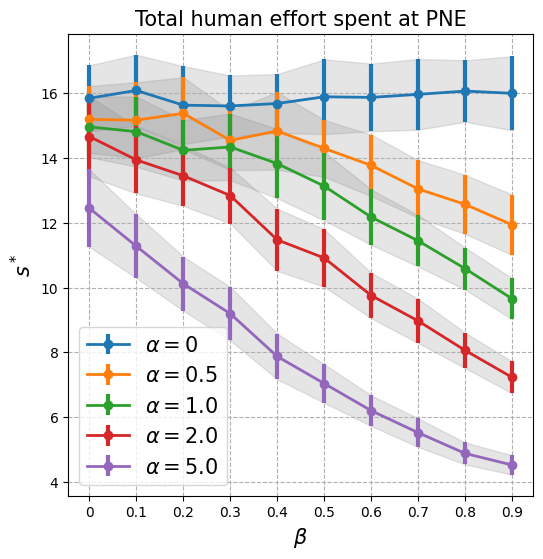

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)/2

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$\alpha=0$', r'$\alpha=0.5$', r'$\alpha=1.0$', r'$\alpha=2.0$', r'$\alpha=5.0$'], fontsize=15)
plt.title('Total human effort spent at PNE', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel(r'$s^*$', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

### Experiment-2 $s-\mu$

In [ ]:
x_vars = [10, 20, 50, 100, 200, 500, 1000]
legend_vars = [5, 10, 20, 50, 100]
trial_num = 100
# observation: s

obs_s0 = np.zeros((trial_num, len(x_vars)))
obs_s = []

for j in range(len(legend_vars)):
    for i in tqdm(range(len(x_vars))):
        for k in range(trial_num):
            n = legend_vars[j]
            c = 1+np.random.poisson(lam=4.0, size=n)
            alpha, beta, gamma, rho = 1.0, 0.5, 0.9, 1.5
            game = Tullock(n=n, mu=x_vars[i], c=c, alpha=alpha, beta=beta, gamma=gamma, rho=rho)
            x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
            x, g, v = game.PGD(x=x0, T=1000, verbose=False)
            s = sum(x)
            obs_s0[k, i] = s
    obs_s.append(obs_s0.copy())




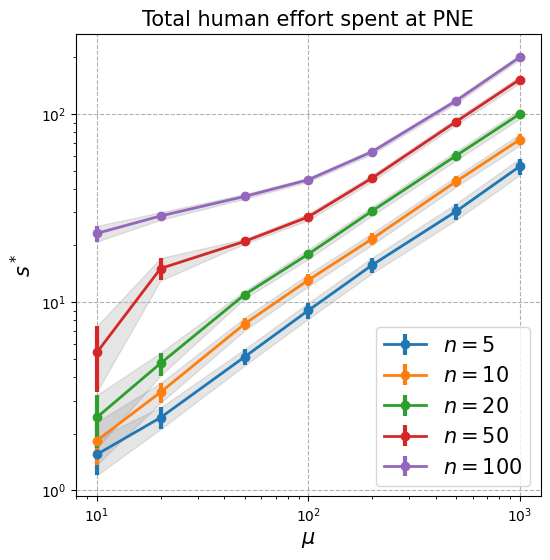

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)/2

    time_points = [10, 20, 50, 100, 200, 500, 1000]

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$n=5$', r'$n=10$', r'$n=20$', r'$n=50$', r'$n=100$'], fontsize=15)
plt.title('Total human effort spent at PNE', fontsize=15)
plt.xlabel(r'$\mu$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel(r'$s^*$', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

### Experiment-3 $W-\beta$

In [ ]:
x_vars = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
legend_vars = [0, 0.5, 1, 2, 5]
gamma, rho = 0.9, 1.5
n, mu = 10, 100
trial_num = 100
# observation: s

obs_s0 = np.zeros((trial_num, len(x_vars)))
obs_s = []

for j in range(len(legend_vars)):
    for i in tqdm(range(len(x_vars))):
        for k in range(trial_num):
            c = 1+np.random.poisson(lam=4.0, size=n)
            game = Tullock(n=n, mu=mu, c=c, alpha=legend_vars[j], beta=x_vars[i], gamma=gamma, rho=rho)
            x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
            x, g, v = game.PGD(x=x0, T=1000, lr=0.03, verbose=False)
            s = sum(game.u(x=x))  # total utility collected
            obs_s0[k, i] = s
    obs_s.append(obs_s0.copy())




100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


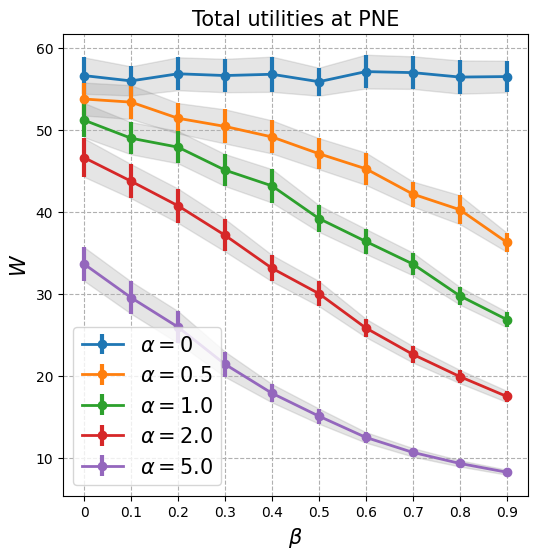

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)/2

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$\alpha=0$', r'$\alpha=0.5$', r'$\alpha=1.0$', r'$\alpha=2.0$', r'$\alpha=5.0$'], fontsize=15)
plt.title('Total utilities at PNE', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel(r'$W$', fontsize=15)
# plt.xscale('log')
# plt.yscale('log')
plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

###Experiment-4 $W-\mu$

In [ ]:
x_vars = [10, 20, 50, 100, 200, 500, 1000]
lr = [0.01, 0.02, 0.02, 0.02, 0.04, 0.07, 0.1]
legend_vars = [5, 10, 20, 50, 100]
alpha, beta, gamma, rho = 1.0, [0.1, 0.5, 0.9], 0.9, 1.5
trial_num = 10
# observation: s

obs_s_beta = []
for beta in beta:

    obs_s0 = np.zeros((trial_num, len(x_vars)))
    obs_s = []

    for j in range(len(legend_vars)):
        for i in tqdm(range(len(x_vars))):
            for k in range(trial_num):
                n = legend_vars[j]
                # c = 1+np.random.poisson(lam=4.0, size=n)
                c = np.random.rand(n) * 9 + 1
                game = Tullock(n=n, mu=x_vars[i], c=c, alpha=alpha, beta=beta, gamma=gamma, rho=rho)
                # x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
                x0 = [0.1] * n
                x, g, v = game.PGD(x=x0, T=1000, lr=lr[i], verbose=False)
                x = np.clip(x, 1e-6, np.inf)
                s = sum(game.u(x=x))  # total utility collected
                obs_s0[k, i] = np.clip(s, 1e-3, np.inf)
        obs_s.append(obs_s0.copy())
    obs_s_beta.append(obs_s.copy())




 43%|████▎     | 3/7 [00:01<00:01,  2.49it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.22it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.64it/s]

 43%|████▎     | 3/7 [00:00<00:00,  7.28it/s]

100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


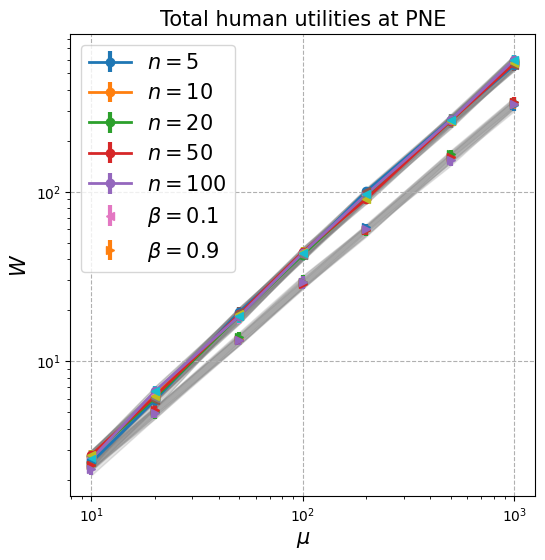

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s_beta[1]:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = [10, 20, 50, 100, 200, 500, 1000]

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

for i in range(len(obs_s_beta[0])):
    data = obs_s_beta[1][i]

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = [10, 20, 50, 100, 200, 500, 1000]

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='<', elinewidth=3, linewidth=2)
    if i==1:
        ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

for i in range(len(obs_s_beta[2])):
    data = obs_s_beta[2][i]

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = [10, 20, 50, 100, 200, 500, 1000]

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='>', elinewidth=3, linewidth=2)
    if i==1:
        ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$n=5$', r'$n=10$', r'$n=20$', r'$n=50$', r'$n=100$', r'$\beta=0.1$', r'$\beta=0.9$'], fontsize=15)
plt.title('Total human utilities at PNE', fontsize=15)
plt.xlabel(r'$\mu$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel(r'$W$', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

In [ ]:
x_vars = [10, 20, 50, 100, 200, 500, 1000]
lr = [0.01, 0.02, 0.02, 0.02, 0.04, 0.07, 0.1]
legend_vars = [5, 10, 20, 50, 100]
alpha, beta, gamma, rho = [0.1, 1.0, 10], 0.5, 0.9, 1.5
trial_num = 10
# observation: s

obs_s_beta = []
for alpha in alpha:

    obs_s0 = np.zeros((trial_num, len(x_vars)))
    obs_s = []

    for j in range(len(legend_vars)):
        for i in tqdm(range(len(x_vars))):
            for k in range(trial_num):
                n = legend_vars[j]
                # c = 1+np.random.poisson(lam=4.0, size=n)
                c = np.random.rand(n) * 9 + 1
                game = Tullock(n=legend_vars[j], mu=x_vars[i], c=c, alpha=alpha, beta=beta, gamma=gamma, rho=rho)
                # x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
                x0 = [0.1] * n
                x, g, v = game.PGD(x=x0, T=1000, lr=lr[i], verbose=False)
                x = np.clip(x, 1e-6, np.inf)
                s = sum(game.u(x=x))  # total utility collected
                obs_s0[k, i] = np.clip(s, 1e-3, np.inf)
        obs_s.append(obs_s0.copy())
    obs_s_beta.append(obs_s.copy())




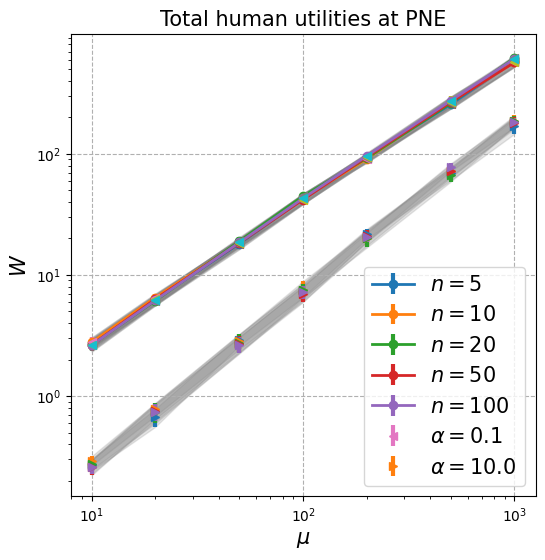

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s_beta[1]:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = [10, 20, 50, 100, 200, 500, 1000]

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

for i in range(len(obs_s_beta[0])):
    data = obs_s_beta[1][i]

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = [10, 20, 50, 100, 200, 500, 1000]

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='<', elinewidth=3, linewidth=2)
    if i==1:
        ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

for i in range(len(obs_s_beta[2])):
    data = obs_s_beta[2][i]

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = [10, 20, 50, 100, 200, 500, 1000]

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='>', elinewidth=3, linewidth=2)
    if i==1:
        ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$n=5$', r'$n=10$', r'$n=20$', r'$n=50$', r'$n=100$', r'$\alpha=0.1$', r'$\alpha=10.0$'], fontsize=15)
plt.title('Total human utilities at PNE', fontsize=15)
plt.xlabel(r'$\mu$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel(r'$W$', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

### Experiment-5

## Extended Game

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class ExtendedTullock(object):
    def __init__(self, n, mu, c, c0, alpha, beta, gamma, rho):
        self.n = n
        self.mu = mu
        self.c = np.array(c)
        self.c0 = c0
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.rho = rho

        self.h = 1e-3
        self.I = np.eye(n)

    def u(self, x, more_info=False):
        if not isinstance(x, np.ndarray):
           x = np.array(x)

        human_index = np.array(x >= 0, dtype=float)
        llm_index = np.array(x < 0, dtype=float)
        s = max(sum(human_index * x), 1)
        H = sum(llm_index)

        b = self.alpha * s**self.beta
        u_human = x / (s**self.gamma + H * b) * self.mu - self.c * np.clip(x, 0, np.inf)**self.rho
        # print(x / (s**self.gamma + H * b) * self.mu)

        u_llm = self.alpha * s**(self.beta-self.gamma+1) / (s**self.gamma + H * b) * self.mu - self.c0

        utility = u_human * human_index + u_llm * llm_index

        if not more_info:
            return utility
        else:
            human_total_u = sum(u_human * human_index)
            human_total_s = sum(x * human_index)
            llm_avg_u = u_llm
            llm_total_u = H * llm_avg_u
            llm_avg_s = self.alpha * s**(1+self.beta-self.gamma)
            llm_total_s = H * llm_avg_s
            if H == n:
                llm_avg_u, llm_avg_s = 0, 0
            else:
                human_avg_u = human_total_u / (n-H)
                human_avg_s = human_total_s / (n-H)
            return utility, (human_total_u, llm_total_u, human_total_s, llm_total_s, human_avg_u, llm_avg_u, human_avg_s, llm_avg_s)


    def solve_PNE(self, x=None, lr=0.1, T=100, max_ite=100, PNE_type='random', verbose=False):

        n = self.n
        if x is None:
            x = np.ones(n)
        else:
            x = np.array(x)


        x = self.solve_sub_PNE(x)
        # solve PNE by enumerating player deviating from human to LLM
        devi_player = 1

        if verbose:
            rangeT = tqdm(range(T))
        else:
            rangeT = range(T)

        for i in rangeT:

            if PNE_type == 'random':
                # randomly pick a player to switch
                l = list(range(n))
                l.remove(devi_player)
                devi_player = np.random.choice(l, 1)[0]
            else:
                # pick the first human player with the highest cost
                devi_player = np.where(x>0)[0][0]

                # print('Current round: ', i)
                # print('picked devi player: ', devi_player)


            # the current PNE given LLM players
            x_devi = x.copy()
            # print('current PNE x: ', x_devi)

            if x[devi_player] < 0:
                # if the picked player is LLM
                x_devi[devi_player] = 1.0
            else:
                # if the picked player is human
                x_devi[devi_player] = -1
            # print('after deviation: ', x_devi)
            # print('pick player: ', devi_player)
            x_devi_NE = self.solve_sub_PNE(x=x_devi, lr=lr, max_ite=max_ite, PNE_type=PNE_type)
            # print('new PNE: ', x_devi_NE)

            u1 = self.u(x_devi_NE)[devi_player]

            u0 = self.u(x)[devi_player]


            if u1 > u0:
                x = x_devi_NE
                # print('New util, old util: ', u1, u0)
                # print('New x: ', np.sum(x<-0.5))
            else:
                # print(i, u1, u0)
                if PNE_type == 'random':
                    pass
                else:
                    break

        return x

    def solve_sub_PNE(self, x, lr=0.1, max_ite=100, PNE_type='random'):

        human_index = np.where(x >= 0)[0]
        llm_index = np.where(x < 0)[0]

        init_x = x[human_index]

        c_sub = self.c[human_index]

        H = self.alpha * len(llm_index)
        sub_game = Tullock(n=len(human_index), mu=self.mu, c=c_sub,
                           alpha=H, beta=self.beta, gamma=self.gamma, rho=self.rho)
        new_x, g, v = sub_game.PGD(x=init_x, lr=lr, T=max_ite, verbose=False)


        x[human_index] = new_x
        x[llm_index] = -1

        return x

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

n, mu, c0 = 100, 1000.0, 0
c = 1+np.random.poisson(lam=4.0, size=n)
c = np.sort(c)[::-1]
alpha, beta, gamma, rho = 0.1, 0.5, 0.9, 1.5

game = ExtendedTullock(n=n, mu=mu, c=c, c0=c0, alpha=alpha, beta=beta, gamma=gamma, rho=rho)
x0 = 2*mu/n/np.array(c)
x = game.solve_PNE(x=x0, lr=0.1, T=100, max_ite=300, PNE_type='random')

x

### Experiment-1 How many human -> LLM

#### time testing

In [ ]:
n, mu, co = 100, 1000, 0
c = 1+np.random.poisson(lam=4.0, size=n)
c = np.sort(c)[::-1]
alpha, beta, gamma, rho = 0.1, 0.9, 0.9, 1.5
game = ExtendedTullock(n=n, mu=mu, c=c, c0=c0, alpha=alpha, beta=beta, gamma=gamma, rho=rho)
x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
x = game.solve_PNE(x=x0, lr=0.05, T=100, max_ite=1000, PNE_type='_random')
sum(x<-0.5)

97

### $(\alpha, \beta)$

In [ ]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)


x_vars = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
legend_vars = [0.01, 0.02, 0.05, 0.1, 0.2]
gamma, rho = 0.9, 1.5
n, mu, co = 100, 1000, 0
trial_num = 10
# observation: s

obs_s0 = np.zeros((trial_num, len(x_vars)))
obs_s = []

for j in range(len(legend_vars)):
    for i in tqdm(range(len(x_vars))):
        for k in range(trial_num):
            # c = 1+np.random.poisson(lam=4.0, size=n)
            c = np.random.rand(n) * 9 + 1
            c = np.sort(c)[::-1]
            game = ExtendedTullock(n=n, mu=mu, c=c, c0=c0, alpha=legend_vars[j], beta=x_vars[i], gamma=gamma, rho=rho)
            x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
            x = game.solve_PNE(x=x0, lr=0.05, T=100, max_ite=1000, PNE_type='_random')
            obs_s0[k, i] = sum(x<-0.5)   # how many LLM players at PNE
    obs_s.append(obs_s0.copy())


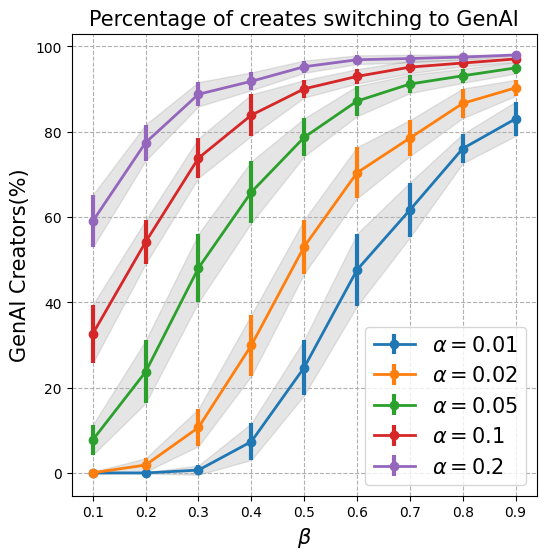

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$\alpha=0.01$', r'$\alpha=0.02$', r'$\alpha=0.05$', r'$\alpha=0.1$', r'$\alpha=0.2$'], fontsize=15)
plt.title('Percentage of creates switching to GenAI', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel('GenAI Creators(%)', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

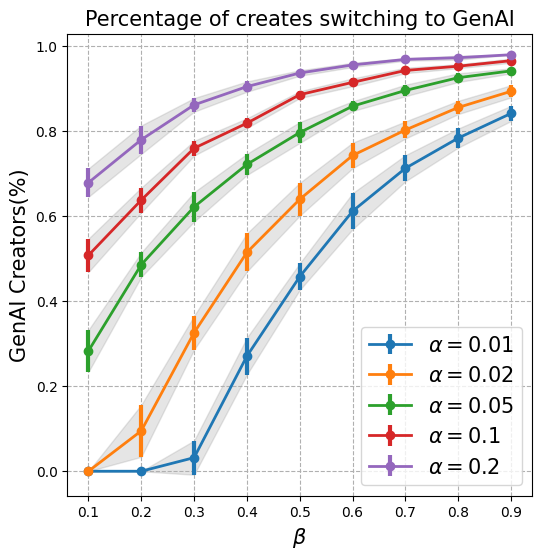

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:

    means = np.mean(data, axis=0)/100
    stds = np.std(data, axis=0)/100

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$\alpha=0.01$', r'$\alpha=0.02$', r'$\alpha=0.05$', r'$\alpha=0.1$', r'$\alpha=0.2$'], fontsize=15)
plt.title('Percentage of creates switching to GenAI', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel('GenAI Creators(%)', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

### $(\mu, n)$

In [ ]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)


x_vars = [50, 100, 200, 500, 1000, 2000, 5000, 10000]
legend_vars = [100, 200, 500, 1000, 2000]
gamma, rho = 0.9, 1.5
alpha, beta, co = 0.05, 0.5, 0
trial_num = 5
# observation: s

obs_s0 = np.zeros((trial_num, len(x_vars)))
obs_s = []

for j in range(len(legend_vars)):
    for i in tqdm(range(len(x_vars))):
        for k in range(trial_num):
            n = legend_vars[j]
            c = 1+np.random.poisson(lam=4.0, size=n)
            c = np.random.rand(n) * 9 + 1
            c = np.sort(c)[::-1]
            game = ExtendedTullock(n=legend_vars[j], mu=x_vars[i], c=c, c0=c0, alpha=alpha, beta=beta, gamma=gamma, rho=rho)
            x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
            x = game.solve_PNE(lr=0.05, T=2000, max_ite=1000, PNE_type='_random')
            obs_s0[k, i] = sum(x<-0.5)   # how many LLM players at PNE
    obs_s.append(obs_s0.copy())


In [ ]:
x[:200]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

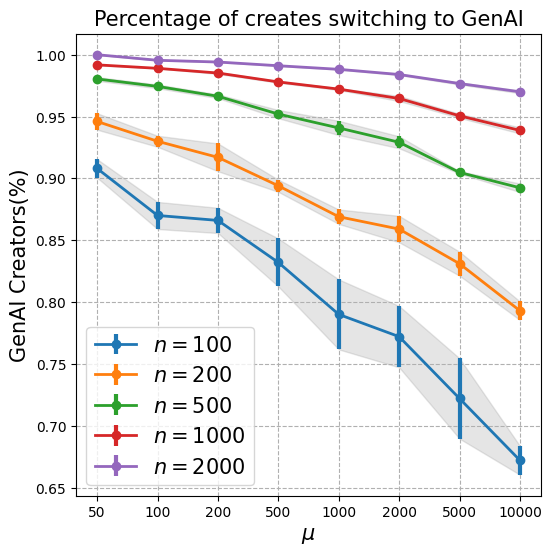

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 3))
ebs = []
for i in range(len(obs_s)):
    data = obs_s[i] / legend_vars[i]

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$n=100$', r'$n=200$', r'$n=500$', r'$n=1000$', r'$n=2000$'], fontsize=12)
plt.title('Percentage of creates switching to GenAI', fontsize=15)
plt.xlabel(r'$\mu$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel('GenAI Creators(%)', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf', bbox_inches='tight')

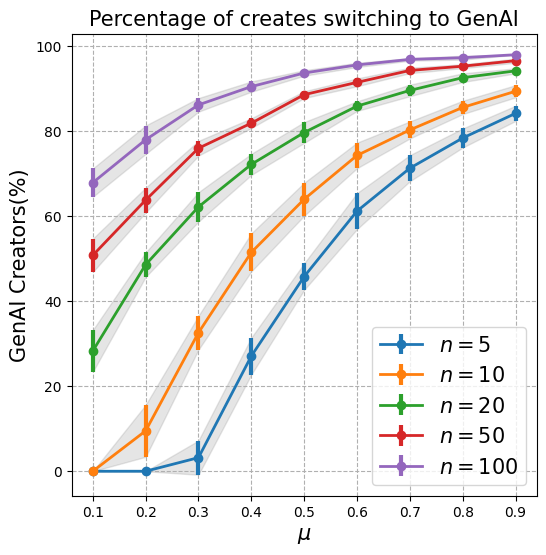

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$n=5$', r'$n=10$', r'$n=20$', r'$n=50$', r'$n=100$'], fontsize=15)
plt.title('Percentage of creates switching to GenAI', fontsize=15)
plt.xlabel(r'$\mu$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel('GenAI Creators(%)', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

### Experiment-2 Who are vulnarable in random PNEs?

### $\beta$

In [ ]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)


alpha, beta, gamma, rho = 0.02, [0.1, 0.3, 0.5, 0.7, 0.9], 0.9, 1.5
n, mu, co = 100, 1000, 0
# c = np.linspace(1, 10, n)
# c = 1+np.random.poisson(lam=4.0, size=n)

trial_num = 10
# observation: s

obs_s = []
res = np.zeros((trial_num, n))

for i in range(len(beta)):
    for k in range(trial_num):

        print('Trial num: ', k)
        c = np.random.rand(n) * 9 + 1
        c = np.sort(c)[::-1]
        game = ExtendedTullock(n=n, mu=mu, c=c, c0=c0, alpha=alpha, beta=beta[i], gamma=gamma, rho=rho)
        x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
        x = game.solve_PNE(x=x0, lr=0.05, T=500, max_ite=1000, PNE_type='random', verbose=False)
        res[k, :] = np.array(x<-0.5, dtype=int)   # mark creators who switch to LLM
    obs_s.append(np.sum(res, axis=0)/trial_num)

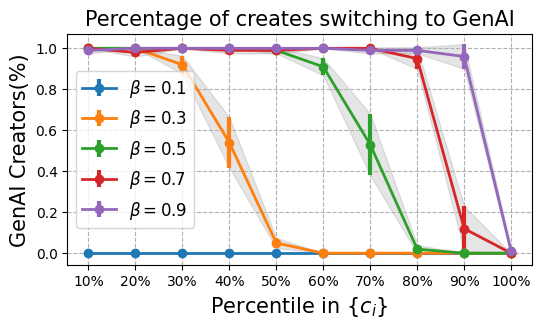

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 3))
ebs = []
for data in obs_s:


    buckets = np.array_split(data, 10)
    means = np.array([np.mean(bucket) for bucket in buckets])

    stds = np.array([np.std(bucket)/2 for bucket in buckets])

    time_points = np.arange(10)

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)


plt.legend(ebs, [r'$\beta=0.1$', r'$\beta=0.3$', r'$\beta=0.5$', r'$\beta=0.7$', r'$\beta=0.9$'], fontsize=12)
plt.title('Percentage of creates switching to GenAI', fontsize=15)
plt.xlabel(r'Percentile in $\{c_i\}$', fontsize=15)
custom_labels = [r'10%', r'20%',r'30%',r'40%',r'50%',r'60%',r'70%',r'80%',r'90%',r'100%']
plt.xticks(time_points, custom_labels)
plt.ylabel('GenAI Creators(%)', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')



### $n$

In [ ]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)


alpha, beta, gamma, rho = 0.02, 0.5, 0.9, 1.5
ns, mu, co = [20, 50, 100, 200, 500], 1000, 0
Ts = [200, 200, 400, 800, 2000]
# c = np.linspace(1, 10, n)
# c = 1+np.random.poisson(lam=4.0, size=n)

trial_num = 5
# observation: s

obs_s = []

for i in range(len(ns)):
    for k in range(trial_num):

        n = ns[i]
        res = np.zeros((trial_num, n))
        print('Trial num: ', k)
        c = np.random.rand(n) * 9 + 1
        c = np.sort(c)[::-1]
        game = ExtendedTullock(n=n, mu=mu, c=c, c0=c0, alpha=alpha, beta=beta, gamma=gamma, rho=rho)
        x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
        x = game.solve_PNE(x=x0, lr=0.05, T=Ts[i], max_ite=1000, PNE_type='random', verbose=False)
        res[k, :] = np.array(x<-0.5, dtype=int)   # mark creators who switch to LLM
    obs_s.append(np.sum(res, axis=0)/trial_num)

In [ ]:
obs_s[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

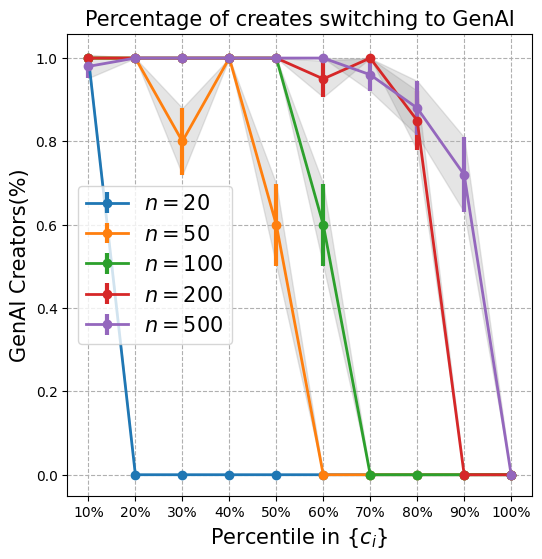

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:


    buckets = np.array_split(data, 10)
    means = np.array([np.mean(bucket) for bucket in buckets]) * 5

    stds = np.array([np.std(bucket) for bucket in buckets])

    time_points = np.arange(10)

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)


plt.legend(ebs, [r'$n=20$',r'$n=50$',r'$n=100$', r'$n=200$', r'$n=500$'], fontsize=15)
plt.title('Percentage of creates switching to GenAI', fontsize=15)
plt.xlabel(r'Percentile in $\{c_i\}$', fontsize=15)
custom_labels = [r'10%', r'20%',r'30%',r'40%',r'50%',r'60%',r'70%',r'80%',r'90%',r'100%']
plt.xticks(time_points, custom_labels)
plt.ylabel('GenAI Creators(%)', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')



### Experiment-3 Compare Human/LLM total utility and effort

In [ ]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)


x_vars = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alpha, gamma, rho = 0.02, 0.9, 1.5
n, mu, co = 100, 1000, 1
trial_num = 10
# observation: s

human_total_u = np.zeros((trial_num, len(x_vars)))
llm_total_u = np.zeros((trial_num, len(x_vars)))
human_total_s = np.zeros((trial_num, len(x_vars)))
llm_total_s = np.zeros((trial_num, len(x_vars)))
human_avg_u = np.zeros((trial_num, len(x_vars)))
llm_avg_u = np.zeros((trial_num, len(x_vars)))
human_avg_s = np.zeros((trial_num, len(x_vars)))
llm_avg_s = np.zeros((trial_num, len(x_vars)))

for i in tqdm(range(len(x_vars))):
    for k in range(trial_num):
        # c = 1+np.random.poisson(lam=4.0, size=n)
        c = np.random.rand(n) * 9 + 1
        c = np.sort(c)[::-1]
        game = ExtendedTullock(n=n, mu=mu, c=c, c0=c0, alpha=alpha, beta=x_vars[i], gamma=gamma, rho=rho)
        x0 = [mu**(1/(gamma+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma+rho-1)) / n] * n
        x = game.solve_PNE(x=x0, lr=0.05, T=300, max_ite=1000, PNE_type='_random')

        _, more_info = game.u(x=x, more_info=True)
        human_total_u[k, i], llm_total_u[k, i], human_total_s[k, i], llm_total_s[k, i], human_avg_u[k, i], llm_avg_u[k, i], human_avg_s[k, i], llm_avg_s[k, i] = more_info



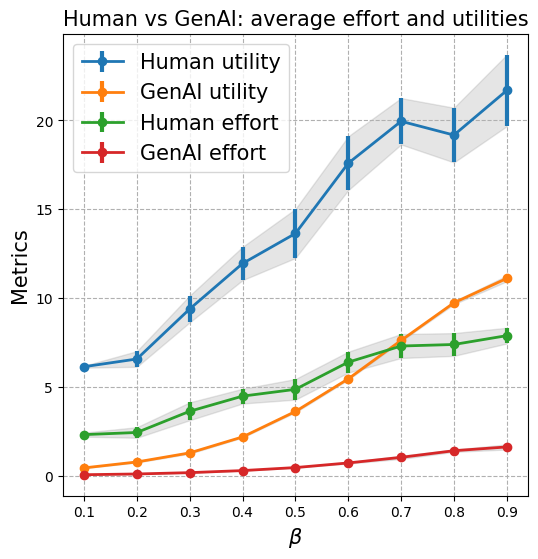

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))

human_vs_llm_total_u = [human_total_u, llm_total_u]
human_vs_llm_total_s = [human_total_s, llm_total_s]
human_vs_llm_avg_u = [human_avg_u, llm_avg_u]
human_vs_llm_avg_s = [human_avg_s, llm_avg_s]

human_vs_llm_total = [human_total_u, llm_total_u, human_total_s, llm_total_s]
human_vs_llm_avg = [human_avg_u, llm_avg_u, human_avg_s, llm_avg_s]
ebs = []

for data in human_vs_llm_avg:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, ['Human utility', 'GenAI utility', 'Human effort', 'GenAI effort'], fontsize=15)
plt.title('Human vs GenAI: average effort and utilities', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel('Metrics', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot1.pdf')

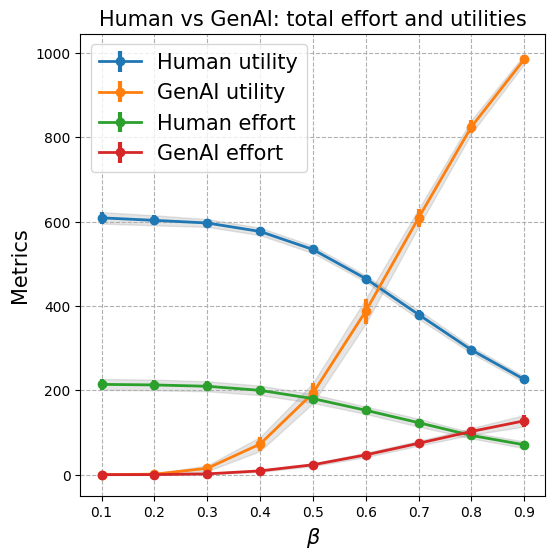

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))

human_vs_llm_total_u = [human_total_u, llm_total_u]
human_vs_llm_total_s = [human_total_s, llm_total_s]
human_vs_llm_avg_u = [human_avg_u, llm_avg_u]
human_vs_llm_avg_s = [human_avg_s, llm_avg_s]

human_vs_llm_total = [human_total_u, llm_total_u, human_total_s, llm_total_s]
human_vs_llm_avg = [human_avg_u, llm_avg_u, human_avg_s, llm_avg_s]
ebs = []

for data in human_vs_llm_total:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, ['Human utility', 'GenAI utility', 'Human effort', 'GenAI effort'], fontsize=15)
plt.title('Human vs GenAI: total effort and utilities', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
plt.ylabel('Metrics', fontsize=15)

plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot2.pdf')

## Tullock contest non-separable cost and PNE solver

### Utility functions

$$u_i(x_i, x_{-i})=\sum_{k=1}^K\frac{x_{ik}}{s_k^{\gamma_k}+\alpha_k \cdot s_k^{\beta_k}}\cdot\mu_k-c_i\left(\sum_{k=1}^Kx_{ik}\right)^{\rho}, i\in[n].$$

where $\mu_k,\alpha_k\geq0, c_i\in[a,b], 1<\rho\leq 2, 1\geq\gamma_k\geq\beta_k\geq 0$, $s_k=\sum_{j=1}^n x_{jk}$.

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class KTullock(object):
    def __init__(self, K, n, mu, c, alpha, beta, gamma, rho):

        self.K = K
        self.n = n
        self.mu = np.array(mu)        # (K, )
        self.c = np.array(c)          # (n, )
        self.alpha = np.array(alpha)  # (K, )
        self.beta = np.array(beta)    # (K, )
        self.gamma = np.array(gamma)  # (K, )
        self.rho = rho

        self.h = 1e-3
        self.I = np.eye(n)

    def u(self, x, more_info=False):
        # x -- (n, K)
        if not isinstance(x, np.ndarray):
           x = np.array(x)

        s = np.sum(x, axis=0)   # (s[0], ..., s[k-1])

        v = np.sum(x/(s**self.gamma+self.alpha * s**self.beta)*self.mu, axis=1) - self.c * (np.sum(x, axis=1) ** self.rho)
        if not more_info:
            return v
        else:
            return v, x/(s**self.gamma+self.alpha * s**self.beta)

    def grad(self, x):
        s = np.sum(x, axis=0)   # (s[0], ..., s[k-1])
        s = np.clip(s, 1e-3, np.infty)
        t0 = s ** self.gamma + self.alpha * s**self.beta
        t1 = self.gamma * s ** (self.gamma-1)
        t2 = self.alpha * self.beta * s ** (self.beta-1)
        g = self.mu / t0 * (1 - x * (t1+t2)/t0) - (self.c * self.rho * np.sum(x, axis=1)**(self.rho-1))[:, np.newaxis]
        return g

    def PGD(self, x=None, lr=0.1, T=100, early_termination=True, verbose=False):
        n, K = self.n, self.K
        if x is None:
            x = np.ones((n, K))
        else:
            x = np.array(x)

        if verbose:
            rangeT = tqdm(range(T))
        else:
            rangeT = range(T)

        for i in rangeT:

            g = self.grad(x)
            x = np.clip(x + g * lr, 0, np.inf)

            if early_termination and np.linalg.norm(x*g) < 1e-4:
                if verbose:
                    print('\nConverge in '+str(i)+' steps!')
                return x, g, self.u(x)

        print('\nWarning: exit before converging. Residual: ', np.linalg.norm(x*g))
        return x, g, self.u(x)

n, K = 10, 5
c = np.sort(1+np.random.poisson(lam=4.0, size=n))
mu = np.array([200, 100, 50, 20, 10])
alpha = [1.0] * K
beta = [0.5] * K
gamma = [0.9] * K
rho = 1.5
game = KTullock(K=K, n=n, mu=mu, c=c, alpha=alpha, beta=beta, gamma=gamma, rho=rho)

# x0 = np.array([[mu[i]**(1/(gamma[i]+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma[i]+rho-1)) / n] * n for i in range(len(mu))]).T
x, g, v = game.PGD(T=5000, lr=0.01, verbose=True)
s = sum(x)

print('\nc: ', c)
print('\nx: ', x)
print('\ns: ', s)
print(np.sum(game.u(x=x, more_info=True)[1], axis=0))


100%|██████████| 5000/5000 [00:01<00:00, 3460.47it/s]



c:  [3 3 3 4 4 5 6 6 7 8]

x:  [[2.9906156  1.26826653 0.52176773 0.15130688 0.04007696]
 [2.9906156  1.26826653 0.52176773 0.15130688 0.04007696]
 [2.9906156  1.26826653 0.52176773 0.15130688 0.04007696]
 [1.89911671 0.79502059 0.32174935 0.09065997 0.02080692]
 [1.89911671 0.79502059 0.32174935 0.09065997 0.02080692]
 [1.30143819 0.53584368 0.21216771 0.05738432 0.01023676]
 [0.94521333 0.38132507 0.14678941 0.03747318 0.00391529]
 [0.94521333 0.38132507 0.14678941 0.03747318 0.00391529]
 [0.71791273 0.28267733 0.10499687 0.02467831 0.        ]
 [0.56376429 0.21573265 0.07658941 0.01592412 0.        ]]

s:  [17.2436221   7.19174456  2.89613472  0.8081737   0.17991206]
[1.00702618 0.83763207 0.67261577 0.46862726 0.28210998]


### Experiment-1 $s/\mu-\beta$ on topic-k

In [ ]:
# metric = 'total human utility per topic'
metric = 'total human effort ratio per topic'

n, K = 10, 5
# c = np.sort(1+np.random.poisson(lam=4.0, size=n))
mu = np.array([200, 100, 50, 20, 10])
alpha = [1.0] * 5
x_vars = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gamma = [0.9] * K
rho = 1.5
trial_num = 10

obs_s = np.zeros((K, trial_num, len(x_vars)))

for i in tqdm(range(len(x_vars))):
    for k in range(trial_num):
        # c = 1+np.random.poisson(lam=4.0, size=n)
        c = (np.random.rand(n) * 9 +1)/10
        game = KTullock(K=K, n=n, mu=mu, c=c, alpha=alpha, beta=[x_vars[i]*K], gamma=gamma, rho=rho)
        x, g, v = game.PGD(T=5000, lr=0.1, verbose=False)
        if metric == 'total human utility per topic':
            obs_s[:, k, i] = np.sum(game.u(x=x, more_info=True)[1], axis=0)
            # x/(s**self.gamma+self.alpha * s**self.beta)
        elif metric == 'total human effort ratio per topic':
            obs_s[:, k, i] = sum(x)/mu  #


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:11<01:40, 11.19s/it]

 70%|███████   | 7/10 [00:25<00:04,  1.52s/it]

 80%|████████  | 8/10 [00:26<00:03,  1.51s/it]

 90%|█████████ | 9/10 [00:29<00:01,  1.96s/it]

100%|██████████| 10/10 [00:34<00:00,  3.43s/it]

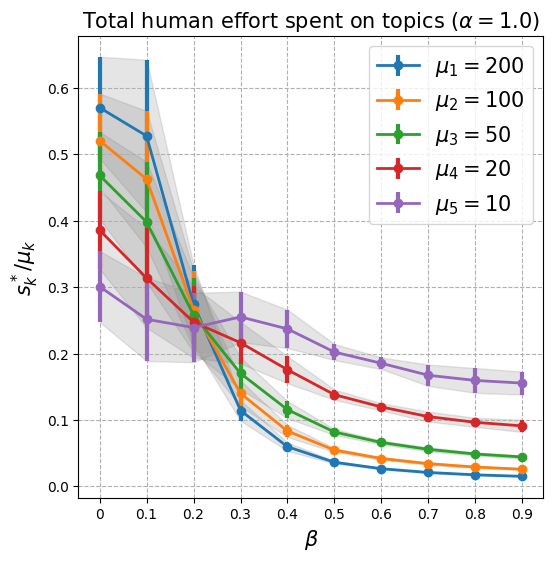

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$\mu_1=200$', r'$\mu_2=100$', r'$\mu_3=50$', r'$\mu_4=20$', r'$\mu_5=10$'], fontsize=15)

if metric == 'total human effort ratio per topic':
    plt.title(r'Total human effort spent on topics ($\alpha=1.0$)', fontsize=15)
else:
    plt.title(r'Avg. human utility on topics ($\alpha=1.0$)', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
if metric == 'total human effort ratio per topic':
    plt.ylabel(r'$s_k^*/\mu_k$', fontsize=15)
else:
    plt.ylabel(r'Avg. $u^{(k)}$ over human creators', fontsize=15)
plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
ebs = []
for data in obs_s:

    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    time_points = np.arange(data.shape[1])

    eb = plt.errorbar(time_points, means, yerr=stds, fmt='-o', elinewidth=3, linewidth=2)
    ebs.append(eb)
    plt.fill_between(time_points, means - stds, means + stds, color='gray', alpha=0.2)

plt.legend(ebs, [r'$\mu_1=200$', r'$\mu_2=100$', r'$\mu_3=50$', r'$\mu_4=20$', r'$\mu_5=10$'], fontsize=15)

if metric == 'total human effort ratio per topic':
    plt.title(r'Total human effort spent on topics ($\alpha=0.1$)', fontsize=15)
else:
    plt.title(r'Avg. human utility on topics ($\alpha=0.1$)', fontsize=15)
plt.xlabel(r'$\beta$', fontsize=15)
custom_labels = [str(v) for v in x_vars]
plt.xticks(time_points, custom_labels)
if metric == 'total human effort ratio per topic':
    plt.ylabel(r'$s_k^*/\mu_k$', fontsize=15)
else:
    plt.ylabel(r'Avg. $u^{(k)}$ over human creators', fontsize=15)
plt.grid(True, linestyle='--')
plt.savefig('error_bar_plot.pdf')

# Finding Non-existence PNE example

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class KTullock(object):
    def __init__(self, K, n, mu, c, alpha, beta, gamma, rho):

        self.K = K
        self.n = n
        self.mu = np.array(mu)        # (K, )
        self.c = np.array(c)          # (n, )
        self.alpha = np.array(alpha)  # (K, )
        self.beta = np.array(beta)    # (K, )
        self.gamma = np.array(gamma)  # (K, )
        self.rho = rho

        self.h = 1e-3
        self.I = np.eye(n)

    def u(self, x, more_info=False):
        # x -- (n, K)
        if not isinstance(x, np.ndarray):
           x = np.array(x)

        s = np.sum(x, axis=0)   # (s[0], ..., s[k-1])

        v = np.sum(x/(s**self.gamma+self.alpha * s**self.beta)*self.mu, axis=1) - self.c * (np.sum(x, axis=1) ** self.rho)
        if not more_info:
            return v
        else:
            return v, x/(s**self.gamma+self.alpha * s**self.beta)

    def grad(self, x):
        s = np.sum(x, axis=0)   # (s[0], ..., s[k-1])
        s = np.clip(s, 1e-3, np.infty)
        t0 = s ** self.gamma + self.alpha * s**self.beta
        t1 = self.gamma * s ** (self.gamma-1)
        t2 = self.alpha * self.beta * s ** (self.beta-1)
        g = self.mu / t0 * (1 - x * (t1+t2)/t0) - (self.c * self.rho * np.sum(x, axis=1)**(self.rho-1))[:, np.newaxis]
        return g

    def PGD(self, x=None, lr=0.1, T=100, early_termination=True, verbose=False):
        n, K = self.n, self.K
        if x is None:
            x = np.ones((n, K))
        else:
            x = np.array(x)

        if verbose:
            rangeT = tqdm(range(T))
        else:
            rangeT = range(T)

        for i in rangeT:

            g = self.grad(x)
            x = np.clip(x + g * lr, 0, np.inf)

            if early_termination and np.linalg.norm(x*g) < 1e-4:
                if verbose:
                    print('\nConverge in '+str(i)+' steps!')
                return x, g, self.u(x)

        print('\nWarning: exit before converging. Residual: ', np.linalg.norm(x*g))
        return x, g, self.u(x)

n, K = 10, 5
c = np.sort(1+np.random.poisson(lam=4.0, size=n))
mu = np.array([200, 100, 50, 20, 10])
alpha = [1.0] * K
beta = [0.5] * K
gamma = [0.9] * K
rho = 1.5
game = KTullock(K=K, n=n, mu=mu, c=c, alpha=alpha, beta=beta, gamma=gamma, rho=rho)

# x0 = np.array([[mu[i]**(1/(gamma[i]+rho-1)) * (sum(c ** (-1/(rho-1))))**((rho-1)/(gamma[i]+rho-1)) / n] * n for i in range(len(mu))]).T
x, g, v = game.PGD(T=5000, lr=0.01, verbose=True)
s = sum(x)

print('\nc: ', c)
print('\nx: ', x)
print('\ns: ', s)
print(np.sum(game.u(x=x, more_info=True)[1], axis=0))


 35%|███▌      | 1766/5000 [00:00<00:01, 1865.04it/s]


Converge in 1766 steps!

c:  [ 2  2  3  4  4  4  5  5  8 10]

x:  [[4.71004832e+00 2.01760531e+00 8.40776844e-01 2.49511324e-01
  9.38866439e-02]
 [4.71004832e+00 2.01760531e+00 8.40776844e-01 2.49511324e-01
  9.38866439e-02]
 [2.58778815e+00 1.09436489e+00 4.48817833e-01 1.29780282e-01
  4.76676320e-02]
 [1.60778824e+00 6.68045022e-01 2.67824399e-01 7.44924875e-02
  2.63252335e-02]
 [1.60778824e+00 6.68045022e-01 2.67824399e-01 7.44924875e-02
  2.63252335e-02]
 [1.60778824e+00 6.68045022e-01 2.67824399e-01 7.44924875e-02
  2.63252335e-02]
 [1.09235783e+00 4.43823426e-01 1.72631349e-01 4.54140003e-02
  1.51002478e-02]
 [1.09235783e+00 4.43823426e-01 1.72631349e-01 4.54140003e-02
  1.51002478e-02]
 [4.78903144e-01 1.76962018e-01 5.93352481e-02 1.08055793e-02
  1.74057491e-03]
 [3.27146084e-01 1.10947363e-01 3.13084387e-02 2.24424959e-03
  0.00000000e+00]]

s:  [19.8220144   8.30926681  3.3697511   0.95615822  0.34635769]
[1.0347621  0.86498543 0.69912462 0.49330041 0.35574196]


## Starting point for player-2

In [ ]:
alpha, beta, rho = 0.27, 0.5, 2.0
mu = [1.0, 1.0]
c = [3.0, 2.0]
c0 = 0.1



In [ ]:
import numpy as np
from scipy.optimize import minimize


def u2_t(x):
    return mu[0]*x[0] / (x[0]+alpha * x[0]**beta) + mu[1]*x[1] / (x[1]+alpha * x[1]**beta) - c[1]*(x[0]+x[1])**rho
def nega_u2_t(x):
    return -u2_t(x)

initial_guess = [0.1, 0.1]
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
    {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
]

result = minimize(nega_u2_t, initial_guess, constraints=constraints)

print("Maximum utility:", -result.fun)
print("Best response:", result.x)
res_x2 = result.x

Maximum utility: 1.0090151423160154
Best response: [0.12396146 0.12396146]


In [ ]:
# 定义二元函数
def u1(x1, x2):
    return mu[0]*x1[0] / (x1[0]+x2[0]) + mu[1]*x1[1] / (x1[1]+x2[1]) - c[0]*(x1[0]+x1[1])**rho
def nega_u1(x1):
    return -u1(x1, x2=res_x2)

initial_guess = [0.1, 0.1]
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
    {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
]

result = minimize(nega_u1, initial_guess, constraints=constraints)

print("Maximum utility:", -result.fun)
print("Best response:", result.x)
res_x1 = result.x

Maximum utility: 0.8259495060871616
Best response: [0.14392659 0.14392659]


In [ ]:
def u2(x2, x1):
    return mu[0] * x2[0] / (x1[0]+x2[0]) + mu[1] * x2[1] / (x1[1]+x2[1]) - c[1]*(x2[0]+x2[1])**rho
def nega_u2(x2):
    return -u2(x2, x1=res_x1)

initial_guess = [0.1, 0.1]
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
    {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
]

result = minimize(nega_u2, initial_guess, constraints=constraints)

print("Maximum utility:", -result.fun)
print("Best response:", result.x)
res_x2_ = result.x

Maximum utility: 0.8524446129427239
Best response: [0.17587671 0.17587671]


In [ ]:
def nega_u1_new(x1):
    return -u1(x1, x2=res_x2_)

initial_guess = [0.1, 0.1]
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
    {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
]

result = minimize(nega_u1_new, initial_guess, constraints=constraints)

print("Maximum utility:", -result.fun)
print("Best response:", result.x)
res_x1_ = result.x

Maximum utility: 0.6515185464657596
Best response: [0.14359717 0.14359717]


## Verify

In [ ]:
def u1_t(x2):
    return mu[0]*alpha * x2[0]**beta / (x2[0]+alpha * x2[0]**beta) + mu[1]*alpha * x2[1]**beta / (x2[1]+alpha * x2[1]**beta) - c0
print('the utility of LLM-p1 when p2 plays x2:', u1_t(x2=res_x2))
print('the utility of Human-p1 when p2 plays x2:', u1(x1=res_x2, x2=res_x2))

assert u1_t(x2=res_x2) < u1(x1=res_x2, x2=res_x2)

the utility of LLM-p1 when p2 plays x2: 0.7680532992661323
the utility of Human-p1 when p2 plays x2: 0.8156026623732218


In [ ]:
print('the utility of LLM-p1 when p2 plays x2_:', u1_t(x2=res_x2_))
print('the utility of Human-p1 when p2 plays x2_:', u1(x1=res_x2_, x2=res_x2_))

assert u1_t(x2=res_x2) > u1(x1=res_x2, x2=res_x2)

In [ ]:
import numpy as np
from scipy.optimize import minimize

alpha, beta, rho = 0.25, 0.5, 2.0
mu = [2.0, 1.0]
c = [2.0, 1.0]
c0 = 0.1

# -------------------------------------------------------------
def u2_t(x):
    return mu[0]*x[0] / (x[0]+alpha * x[0]**beta) + mu[1]*x[1] / (x[1]+alpha * x[1]**beta) - c[1]*(x[0]+x[1])**rho
def nega_u2_t(x):
    return -u2_t(x)

initial_guess = [0.1, 0.1]
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
    {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
]

result = minimize(nega_u2_t, initial_guess, constraints=constraints)

print("Maximum utility:", -result.fun)
print("Best response:", result.x)
res_x2 = result.x

# -------------------------------------------------------------

def u1(x1, x2):
    return mu[0]*x1[0] / (x1[0]+x2[0]) + mu[1]*x1[1] / (x1[1]+x2[1]) - c[0]*(x1[0]+x1[1])**rho
def nega_u1(x1):
    return -u1(x1, x2=res_x2)


initial_guess = [0.1, 0.1]
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
    {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
]

result = minimize(nega_u1, initial_guess, constraints=constraints)

print("Maximum utility:", -result.fun)
print("Best response:", result.x)
res_x1 = result.x

# -------------------------------------------------------------

def u2(x2, x1):
    return mu[0] * x2[0] / (x1[0]+x2[0]) + mu[1] * x2[1] / (x1[1]+x2[1]) - c[1]*(x2[0]+x2[1])**rho
def nega_u2(x2):
    return -u2(x2, x1=res_x1)


initial_guess = [0.1, 0.1]
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
    {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
]

result = minimize(nega_u2, initial_guess, constraints=constraints)

print("Maximum utility:", -result.fun)
print("Best response:", result.x)
res_x2_ = result.x

# -------------------------------------------------------------
def nega_u1_new(x1):
    return -u1(x1, x2=res_x2_)


initial_guess = [0.1, 0.1]
constraints = [
    {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
    {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
]

result = minimize(nega_u1_new, initial_guess, constraints=constraints)

print("Maximum utility:", -result.fun)
print("Best response:", result.x)
res_x1_ = result.x


def u1_t(x2):
    return mu[0]*alpha * x2[0]**beta / (x2[0]+alpha * x2[0]**beta) + mu[1]*alpha * x2[1]**beta / (x2[1]+alpha * x2[1]**beta) - c0
print('the utility of LLM-p1 when p2 plays x2:', u1_t(x2=res_x2))
print('the utility of Human-p1 when p2 plays x2:', u1(x1=res_x2, x2=res_x2))

assert u1_t(x2=res_x2) < u1(x1=res_x2, x2=res_x2)
print('the utility of LLM-p1 when p2 plays x2_:', u1_t(x2=res_x2_))
print('the utility of Human-p1 when p2 plays x2_:', u1(x1=res_x2_, x2=res_x2_))

assert u1_t(x2=res_x2_) > u1(x1=res_x2_, x2=res_x2_)

Maximum utility: 1.7817987567148115
Best response: [0.2667066  0.14519608]
Maximum utility: 1.163073479847445
Best response: [0.28847189 0.14446714]
Maximum utility: 1.3826349717611608
Best response: [0.40248917 0.20135017]
Maximum utility: 0.8780194245818989
Best response: [0.28440039 0.14216741]
the utility of LLM-p1 when p2 plays x2: 0.9485374304779112
the utility of Human-p1 when p2 plays x2: 1.1606723743854452
the utility of LLM-p1 when p2 plays x2_: 0.82313885330353
the utility of Human-p1 when p2 plays x2_: 0.7707561130666953


In [ ]:
import numpy as np
from scipy.optimize import minimize

alpha, beta, rho = 0.25, 0.5, 2.0
mu = [2.0, 1.0]
c = [2.0, 1.0]
c0 = 0.1

def verify_PNE(alpha, beta, rho, mu, c, c0):
    # -------------------------------------------------------------
    def u2_t(x):
        # p2's util of x when p1 is using llm
        return mu[0]*x[0] / (x[0]+alpha * x[0]**beta) + mu[1]*x[1] / (x[1]+alpha * x[1]**beta) - c[1]*(x[0]+x[1])**rho
    def nega_u2_t(x):
        return -u2_t(x)

    initial_guess = [0.1, 0.1]
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
        {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
    ]

    result = minimize(nega_u2_t, initial_guess, constraints=constraints)

    print("Maximum utility:", -result.fun)
    print("Best response:", result.x)
    res_x2 = result.x

    # -------------------------------------------------------------

    def u1(x1, x2):
        return mu[0]*x1[0] / (x1[0]+x2[0]) + mu[1]*x1[1] / (x1[1]+x2[1]) - c[0]*(x1[0]+x1[1])**rho
    def nega_u1(x1):
        return -u1(x1, x2=res_x2)

    initial_guess = [0.1, 0.1]
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
        {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
    ]

    result = minimize(nega_u1, initial_guess, constraints=constraints)

    print("Maximum utility:", -result.fun)
    print("Best response:", result.x)
    res_x1 = result.x

    # -------------------------------------------------------------

    def u2(x2, x1):
        return mu[0] * x2[0] / (x1[0]+x2[0]) + mu[1] * x2[1] / (x1[1]+x2[1]) - c[1]*(x2[0]+x2[1])**rho
    def nega_u2(x2):
        return -u2(x2, x1=res_x1)

    initial_guess = [0.1, 0.1]
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
        {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
    ]

    result = minimize(nega_u2, initial_guess, constraints=constraints)

    print("Maximum utility:", -result.fun)
    print("Best response:", result.x)
    res_x2_ = result.x

    # -------------------------------------------------------------
    def nega_u1_new(x1):
        return -u1(x1, x2=res_x2_)

    initial_guess = [0.1, 0.1]
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0]-1e-4},
        {'type': 'ineq', 'fun': lambda x: x[1]-1e-4}
    ]

    result = minimize(nega_u1_new, initial_guess, constraints=constraints)

    print("Maximum utility:", -result.fun)
    print("Best response:", result.x)
    res_x1_ = result.x


    def u1_t(x2):
        return mu[0]*alpha * x2[0]**beta / (x2[0]+alpha * x2[0]**beta) + mu[1]*alpha * x2[1]**beta / (x2[1]+alpha * x2[1]**beta) - c0
    print('the utility of LLM-p1 when p2 plays x2:', u1_t(x2=res_x2))
    print('the utility of Human-p1 when p2 plays x2:', u1(x1=res_x2, x2=res_x2))


    print('the utility of LLM-p1 when p2 plays x2_:', u1_t(x2=res_x2_))
    print('the utility of Human-p1 when p2 plays x2_:', u1(x1=res_x2_, x2=res_x2_))

    # assert u1_t(x2=res_x2) < u1(x1=res_x2, x2=res_x2)
    # assert u1_t(x2=res_x2_) > u1(x1=res_x2_, x2=res_x2_)
    if u1_t(x2=res_x2) < u1(x1=res_x2, x2=res_x2) and u1_t(x2=res_x2_) > u1(x1=res_x2_, x2=res_x2_):
        print('Not PNE verified!')
    else:
        print('failed.')

# alpha, beta, rho = 0.4, 0.5, 2.0
# mu = [20.0, 10.0]
# c = [7.0, 7.0]
# c0 = 0.1

alpha, beta, rho = 0.25, 0.5, 2.0
mu = [2.0, 1.0]
c = [7.0, 7.0]
c0 = 0.1


verify_PNE(alpha=alpha, beta=beta, rho=rho, mu=mu, c=c, c0=c0)

Maximum utility: 1.4339404508980373
Best response: [0.10778933 0.05482661]
Maximum utility: 1.387213519231774
Best response: [0.15198028 0.07617672]
Maximum utility: 1.1357639466020666
Best response: [0.15433968 0.07716914]
Maximum utility: 1.1248256521167488
Best response: [0.1543252  0.07718252]
the utility of LLM-p1 when p2 plays x2: 1.2809519430981688
the utility of Human-p1 when p2 plays x2: 1.3148923939962065
the utility of LLM-p1 when p2 plays x2_: 1.151443482098606
the utility of Human-p1 when p2 plays x2_: 1.1248256560318461
Not PNE verified!
